## A notebook for the Technical Validation part of the paper

## Import and install libraries

In [29]:
%pip install pandas seaborn matplotlib requests statsmodels
 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter
import requests
import matplotlib.colors as mcolors
import matplotlib as mpl
import os


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Global settings

In [30]:
# set theme
sns.set_theme(rc={'figure.figsize': (11,7)})

# Set global font sizes using rcParams
plt.rcParams.update({
    "axes.titlesize": 27,    # Font size for plot titles
    "axes.labelsize": 18,    # Font size for x and y labels
    "xtick.labelsize": 17,   # Font size for x-axis tick labels
    "ytick.labelsize": 17,  # Font size for y-axis tick labels
    "legend.fontsize": 17,
    "legend.title_fontsize":17
})

## Growth of Uberon and CL over time from other sources

In [31]:
# load data
df_uberon_cl_growth = pd.read_csv(
    "output/other-ontologies-growth.csv", parse_dates=['date'])
df_uberon_cl_growth

,ontology,date,nodes,node_types,edges,edge_types
0,uberon,2025-05-28,16010,16016,49551,22
1,uberon,2025-04-09,15984,15990,49456,22
2,uberon,2025-01-15,15959,15965,50974,22
3,uberon,2024-11-25,15942,15948,50888,22
4,uberon,2024-09-03,15937,15943,50781,22
...,...,...,...,...,...,...
77,provisional-cell-ontology,2022-01-07,1827,1880,5142,7
78,provisional-cell-ontology,2021-12-17,1825,1875,5132,6
79,provisional-cell-ontology,2021-12-08,1824,1873,5115,5
80,provisional-cell-ontology,2021-12-03,1824,1873,5115,5


In [32]:
# make long and tidy, then sort by date
df_uberon_cl_growth_long = pd.melt(df_uberon_cl_growth, id_vars=[
                                   'ontology', 'date'], var_name='type', value_name='count')
df_uberon_cl_growth_long

,ontology,date,type,count
0,uberon,2025-05-28,nodes,16010
1,uberon,2025-04-09,nodes,15984
2,uberon,2025-01-15,nodes,15959
3,uberon,2024-11-25,nodes,15942
4,uberon,2024-09-03,nodes,15937
...,...,...,...,...
323,provisional-cell-ontology,2022-01-07,edge_types,7
324,provisional-cell-ontology,2021-12-17,edge_types,6
325,provisional-cell-ontology,2021-12-08,edge_types,5
326,provisional-cell-ontology,2021-12-03,edge_types,5


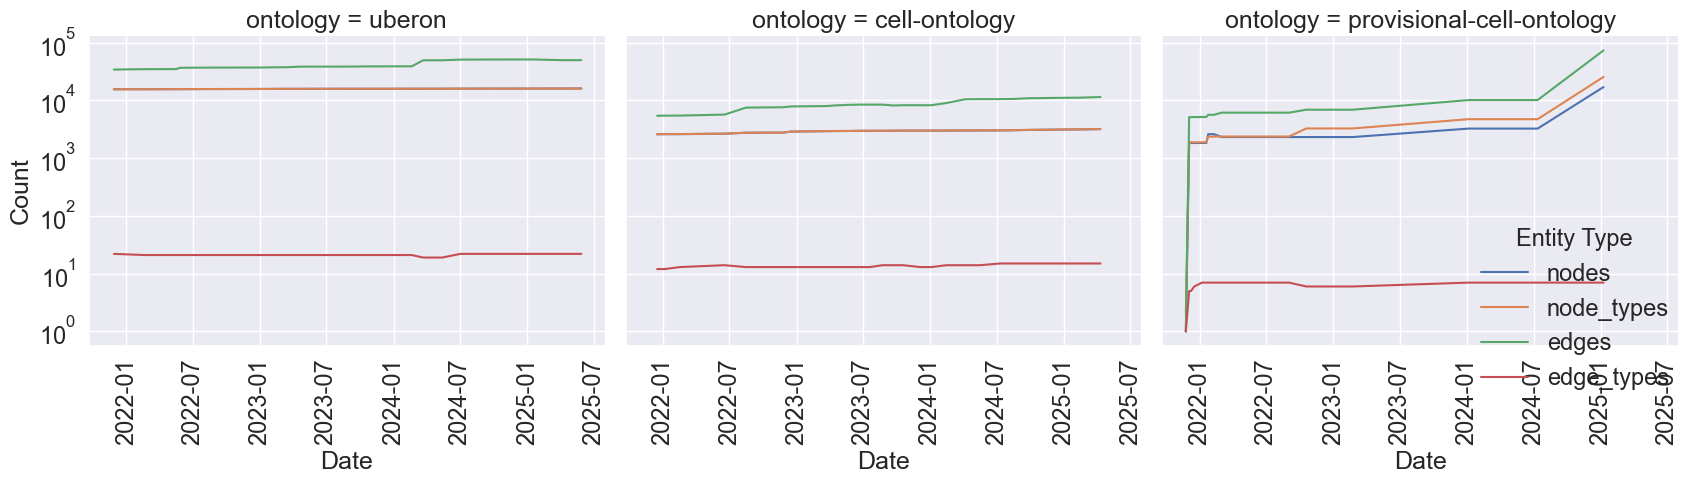

In [33]:
# visualize
g = sns.relplot(
    data=df_uberon_cl_growth_long,
  x='date',
  y='count',
  hue='type',
  col='ontology',
  kind='line'
)

# Rotate x-axis labels for better readability
for ax in g.axes.flat:
    plt.setp(ax.get_xticklabels(), rotation=90)
    ax.get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

# set axis labels
g.set_xlabels('Date')
g.set_ylabels('Count')

# Set y-axis to logarithmic scale
plt.yscale('log')

# Adjust legend
g._legend.set_bbox_to_anchor((.99, 0.35))  # Adjust position
g._legend.set_title('Entity Type')

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()

In [34]:
# compute basic stats
print('Max number of nodes per ontology:')
print(f'{df_uberon_cl_growth.groupby(['ontology'])['nodes'].max()}')
print()

print('Max number of edges per ontology:')
print(f'{df_uberon_cl_growth.groupby(['ontology'])['edges'].max()}')
print()

print('Max number of edge types per ontology:')
print(f'{df_uberon_cl_growth.groupby(['ontology'])['edge_types'].max()}')
print()

Max number of nodes per ontology:
ontology
cell-ontology                 3171
provisional-cell-ontology    16980
uberon                       16010
Name: nodes, dtype: int64

Max number of edges per ontology:
ontology
cell-ontology                11407
provisional-cell-ontology    73125
uberon                       50974
Name: edges, dtype: int64

Max number of edge types per ontology:
ontology
cell-ontology                15
provisional-cell-ontology     7
uberon                       22
Name: edge_types, dtype: int64



## (1) HRA growth over time

In [35]:
# import HRA growth
growth = pd.read_csv(
    'https://raw.githubusercontent.com/x-atlas-consortia/hra-dashboard-data/ccf0e3274d615523e89ba034dddeb9c64ffb3162/data/data/hra-growth.csv')
growth

,group,date,count,order
0,tissue providers,2020-02-10,1,1
1,tissue providers,2020-02-12,1,1
2,tissue providers,2020-05-18,1,1
3,tissue providers,2021-02-10,1,1
4,tissue providers,2021-03-16,2,1
...,...,...,...,...
110,SOPs,2023-10-18,1,10
111,SOPs,2023-12-11,1,10
112,SOPs,2023-12-13,1,10
113,SOPs,2024-06-12,6,10


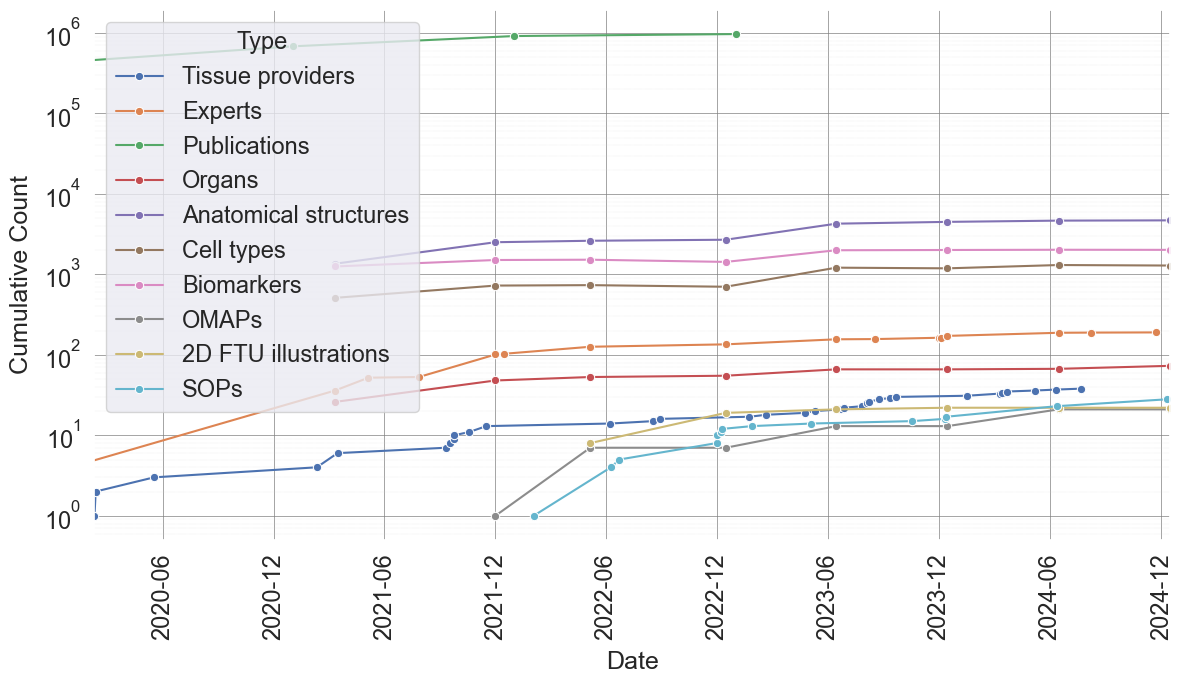

In [36]:
# vega-lite spec: https://cdn.humanatlas.io/hra-dashboard-data/data/hra-growth.vl.json

# Convert date to datetime
growth['date'] = pd.to_datetime(growth['date'])

# Calculate cumulative sum
growth['cumulative_count'] = growth.groupby("group")['count'].cumsum()

# Create the line plot
g = sns.lineplot(
    data=growth,
    x='date',
    y='cumulative_count',
    hue='group',
    marker='o'
)

# Customize the plot
plt.xlabel('Date')
plt.ylabel('Cumulative Count')

# Get axes
ax=plt.gca()

# adjust legend
# Get handles and current labels
handles, labels = ax.get_legend_handles_labels()

# Capitalize each label
new_labels = [label if label == 'SOPs' or label == 'OMAPs' or label == '2D FTU illustrations' else label.capitalize() for label in labels]

# Apply the new labels
ax.legend(handles=handles, 
          labels=new_labels, 
          title='Type',
          loc='upper left')  # optional new title

# increase figure size to accommodate facet grid
g.figure.set_size_inches(12, 7)

# Make sure all minor ticks are visible
ax.tick_params(which='both', direction='out', length=6)

# Set y-axis to logarithmic scale
plt.yscale('log')

# adjust labels
plt.xlabel('Date', labelpad=8)
plt.ylabel('Cumulative Count', labelpad=8)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Set major ticks only on June and December (HRA releases)
ax.xaxis.set_major_locator(MonthLocator(bymonth=[6, 12]))
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))

plt.grid(True, which='both', axis='x', linestyle='-',
         linewidth=2)  # Apply grid to x-axis

# Set white background
g.figure.set_facecolor('white')
ax.set_facecolor('white')

# Set thin grey grid lines
ax.grid(True, which='major', axis='both',
        linestyle='-', linewidth=0.5, color='grey')
ax.grid(True, which='minor', axis='both',
        linestyle=':', linewidth=0.3, color='lightgrey')



# Set the x-axis limits
filtered_data = growth.dropna()[growth['date'] >= '2020-02']
plt.xlim(filtered_data["date"].min(), filtered_data["date"].max())

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.savefig(f"output/b_hra_growth_over_time.pdf",
            dpi=600, format='pdf', bbox_inches='tight')

plt.show()

## (2) DOs per organ

In [37]:
# import DOs per organ
dos_per_organ = pd.read_csv(
    'https://raw.githubusercontent.com/x-atlas-consortia/hra-dashboard-data/daa49797509e9485bbb379bb08f3feb5299fa86f/data/data/digital-objects-per-organ.csv')
dos_per_organ

,organ,type,count
0,anatomical systems,ASCT+B Table,1
1,blood,CTAnn Crosswalks,3
2,blood pelvis,ASCT+B Table,1
3,blood vasculature,ASCT+B Table,1
4,blood vasculature,CTAnn Crosswalks,1
...,...,...,...
101,uterus,ASCT+B Table,1
102,uterus,CTAnn Crosswalks,1
103,uterus,3D Reference Organ,2
104,vascular system,CTAnn Crosswalks,1


In [38]:
# adjust strings
dos_per_organ['type'] = dos_per_organ['type'].replace(
  {
      'CTAnn Crosswalks': 'CTann Crosswalk'
  }
)
dos_per_organ

,organ,type,count
0,anatomical systems,ASCT+B Table,1
1,blood,CTann Crosswalk,3
2,blood pelvis,ASCT+B Table,1
3,blood vasculature,ASCT+B Table,1
4,blood vasculature,CTann Crosswalk,1
...,...,...,...
101,uterus,ASCT+B Table,1
102,uterus,CTann Crosswalk,1
103,uterus,3D Reference Organ,2
104,vascular system,CTann Crosswalk,1


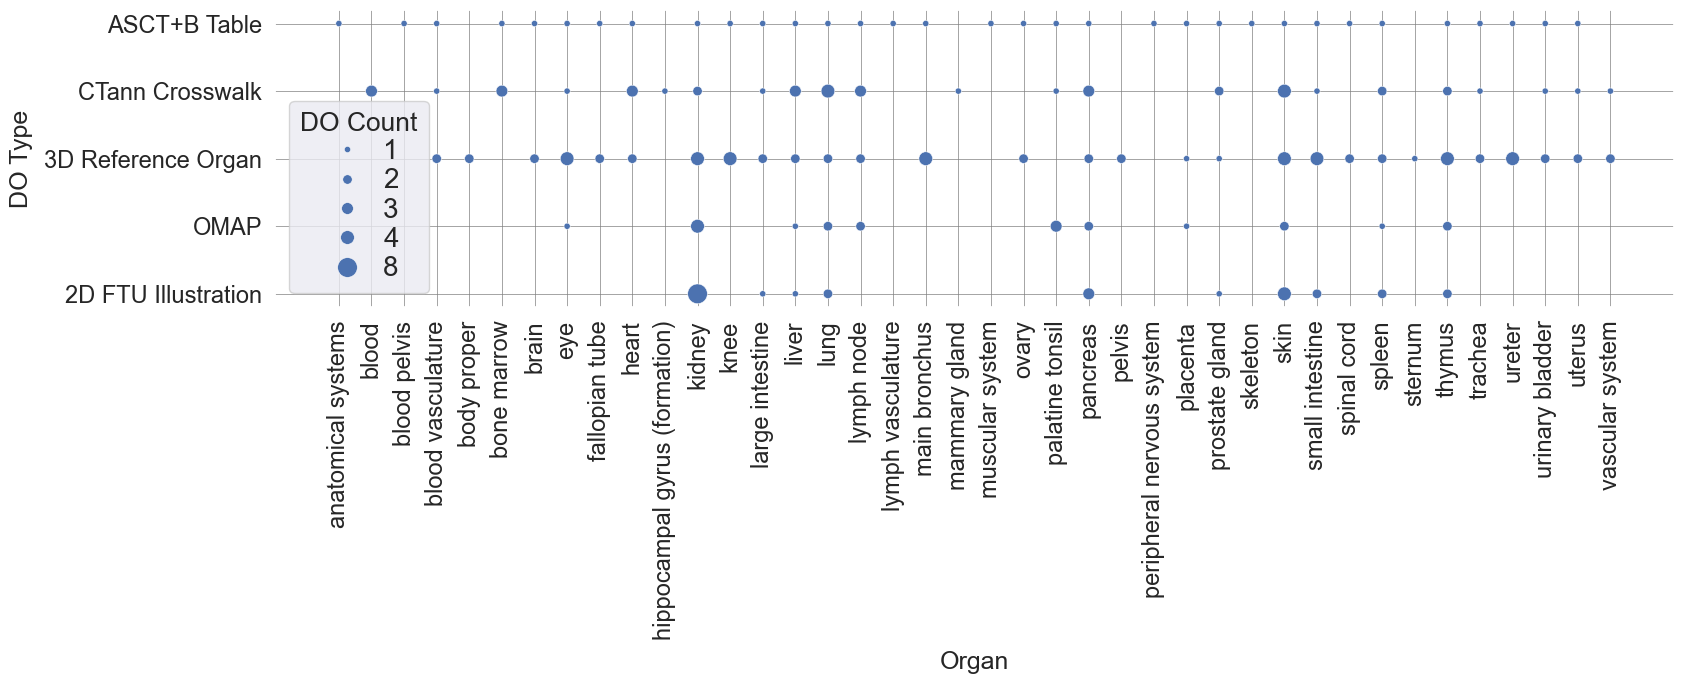

In [45]:
# vega-lite spec: https://cdn.humanatlas.io/hra-dashboard-data/data/digital-objects-per-organ.vl.json

dos_per_organ

color_map = sns.choose_colorbrewer_palette("YlGnBu", as_cmap=True)

# Create the line plot
g = sns.scatterplot(
    data=dos_per_organ,
   x="organ",
   y="type",
   size="count",
   sizes=(20, 200)
)

# Set white background for figure and axes
g.figure.set_facecolor('white')
g.set_facecolor('white')

# Set thin grey grid lines
g.grid(True, which='major', axis='both',
       linestyle='-', linewidth=0.5, color='grey')
g.grid(True, which='minor', axis='both',
       linestyle=':', linewidth=0.3, color='lightgrey')


# increase figure size to accommodate facet grid
g.figure.set_size_inches(17, 7)

# uncomment if needed
# g.legend_.remove()

# Customize the plot
plt.xlabel('Organ', labelpad=8)
plt.ylabel('DO Type', labelpad=8)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# adjust legend
legend = g.legend(title='DO Count',
                  loc='lower left',
                  labelspacing=0.12, fontsize=20, title_fontsize=19,
                  # bbox_to_anchor=(0, -.5)
                  handletextpad=0.3,
                  )

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.savefig(f"output/a_dos_per_organ.pdf",
            dpi=600, format='pdf', bbox_inches='tight')

plt.show()

## (3) Ontology terms added over time

In [40]:
# import ontoloogies extended over time
ontology_terms_added = pd.read_csv(
  # 'https://raw.githubusercontent.com/x-atlas-consortia/hra-dashboard-data/084f1c9543459044635671fc2b25672495f88afe/data/data/ontology-terms-added.csv'
  'https://raw.githubusercontent.com/x-atlas-consortia/hra-dashboard-data/refs/heads/main/data/data/ontology-terms-added.csv'
  )
ontology_terms_added

,date,count,ontology
0,2023-01-01,50,CL
1,2023-02-15,14,CL
2,2023-03-21,11,CL
3,2023-04-20,11,CL
4,2023-05-22,5,CL
5,2023-06-22,7,CL
6,2023-07-20,0,CL
7,2023-08-24,6,CL
8,2023-09-21,2,CL
9,2023-10-19,5,CL


In [41]:
ontology_terms_added = ontology_terms_added.rename(columns=
  {
    'ontology':'Ontology'
  }
)

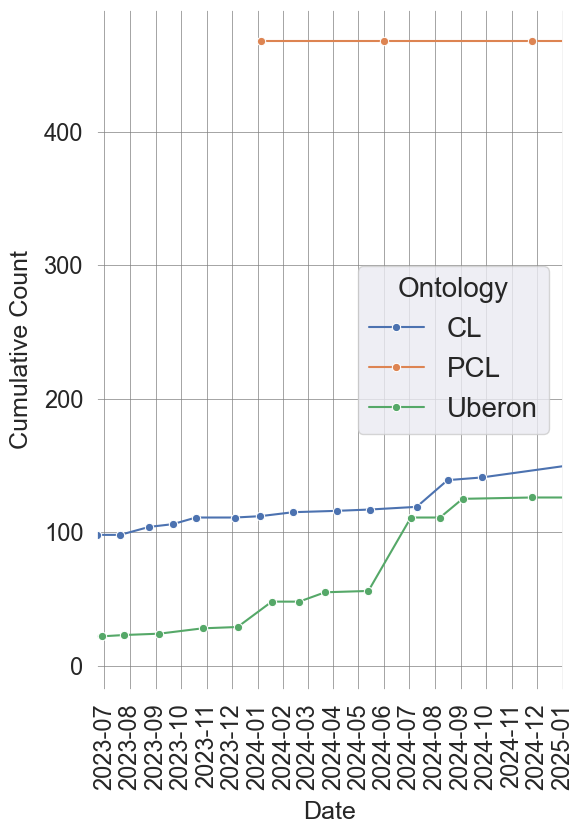

In [42]:
# vega-lite spec: https://cdn.humanatlas.io/hra-dashboard-data/data/ontology-terms-added.vl.json

# Convert date to datetime
ontology_terms_added['date'] = pd.to_datetime(ontology_terms_added['date'])

# Calculate cumulative sum
ontology_terms_added['cumulative_count'] = ontology_terms_added.groupby("Ontology")[
    'count'].cumsum()

# Create the line plot
g = sns.lineplot(
    data=ontology_terms_added,
    x='date',
    y='cumulative_count',
    hue='Ontology',
    marker='o'
)

# adjust labels
plt.xlabel('Date', labelpad=8)
plt.ylabel('Cumulative Count', labelpad=8)

# Set monthly ticks
ax = plt.gca()  # get current axis
# set ticks to appear at start of each month
ax.xaxis.set_major_locator(MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))  # format as YYYY-MM

# Get axes
ax = plt.gca()

# set legend font size
ax.legend(title='Ontology', fontsize=20, title_fontsize=20, loc='center right')  # sets size of legend entries

# Make sure all minor ticks are visible
ax.tick_params(which='both', direction='out', length=6)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Set the x-axis limits
filtered_data = ontology_terms_added.dropna()[ontology_terms_added['date'] >= "2023-06"]
plt.xlim(filtered_data["date"].min(), pd.Timestamp("2025-01-01"))

# Set white background
g.figure.set_facecolor('white')
ax.set_facecolor('white')

# Set thin grey grid lines
ax.grid(True, which='major', axis='both',
        linestyle='-', linewidth=0.5, color='grey')
# ax.grid(True, which='minor', axis='both',
#         linestyle=':', linewidth=0.3, color='lightgrey')


# adjust figure size 
g.figure.set_size_inches(6, 8.5)

plt.savefig(f"output/c_ontologies_extended.pdf",
            dpi=600, format='pdf', bbox_inches='tight')

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()